# Figure Generation for Manuscript

This notebook generates **Supplementary Figures S1 and S3**.  
Figures are based on the *Saccharomyces cerevisiae* genetic interaction (GI) network from **Costanzo et al. (2016)**.

---

## Supplementary Figure S1: RISK Analysis of GI Network
- Yeast GI network (3,641 nodes, 23,562 edges)  
- Louvain clustering with RISK  
- GO BP annotation of clusters  
- Network visualization panels

## Supplementary Figure S3: RISK vs SAFE Comparison
- Yeast GI network  
- RISK clusters (Louvain)  
- SAFE clusters (shortest-path)  
- Side-by-side visual comparison of clustering results

---

### Workflow
- **Input:** Yeast GI network (Costanzo et al., 2016)  
- **Tools:** Python, RISK, SAFE, NetworkX, Matplotlib  
- **Output:** High-resolution figures for **Supplementary Figures S1 and S3**

In [26]:
# First, load the Costanzo et al., 2016 network

import json
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def read_json(file_path):
    with open(file_path, "r") as file:
        return json.load(file)


def read_gpickle(filepath):
    with open(filepath, "rb") as f:
        G = pickle.load(f)
    return G


costanzo_network_path = "./data/gpickle/costanzo_2016.gpickle"
costanzo_gpickle = read_gpickle(costanzo_network_path)

print(len(costanzo_gpickle.nodes()))
print(len(costanzo_gpickle.edges()))

3641
23714


In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import risk

# Check the version of the RISK package to ensure it's installed correctly
risk.__version__

'0.0.14-beta.2'

In [28]:
%matplotlib inline

In [29]:
# Initialize the RISK object

from risk import RISK

risk = RISK(verbose=True)

In [30]:
# Load the network from a Cytoscape file for RISK analysis
network = risk.load_network_networkx(
    network=costanzo_gpickle,
    compute_sphere=False,
    surface_depth=0.1,
    min_edges_per_node=0,
)

# Load GO Biological Process (BP) annotations from a JSON file and associate them with the existing network
annotation = risk.load_annotation_json(
    network=network,
    filepath="./data/json/annotations/go_biological_process.json",
    min_nodes_per_term=1,
)

---------------
Loading network
---------------
Filetype: NetworkX
Minimum edges per node: 0
Projection: Plane
3641 out of 3641 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.
Initial node count: 3641
Final node count: 3641
Initial edge count: 23714
Final edge count: 23562
------------------
Loading annotation
------------------
Filetype: JSON
Filepath: ./data/json/annotations/go_biological_process.json
Minimum number of nodes per annotation term: 1
Maximum number of nodes per annotation term: 10000
Number of input annotation terms: 2214
Number of remaining annotation terms: 2138


In [31]:
# Perform annotation significance analysis by computing p-values for network neighborhoods using the permutation test

neighborhoods = risk.load_neighborhoods_permutation(
    network=network,
    annotation=annotation,
    distance_metric="louvain",
    louvain_resolution=2.0,
    leiden_resolution=1.0,
    fraction_shortest_edges=0.25,
    score_metric="stdev",
    null_distribution="network",
    num_permutations=1_000,
    random_seed=887,
    max_workers=7,
)

------------------------
Running permutation test
------------------------
Neighborhood scoring metric: 'stdev'
Number of permutations: 1000
Maximum workers: 7
Null distribution: 'network'
Distance metric: 'louvain (resolution=2.0)'
Edge length threshold: 0.25
Random seed: 887


Total progress: 100%|████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.95it/s]


In [32]:
# Get the NetworkGraph object for plotting

graph = risk.load_graph(
    network=network,
    annotation=annotation,
    neighborhoods=neighborhoods,
    tail="right",
    pval_cutoff=0.005,
    fdr_cutoff=1.00,
    impute_depth=0,
    prune_threshold=0.06,
    linkage_criterion="distance",
    linkage_method="single",
    linkage_metric="sokalsneath",
    linkage_threshold=0.001,
    min_cluster_size=8,
    max_cluster_size=1_000,
)

---------------------------------
Finding significant neighborhoods
---------------------------------
p-value cutoff: 0.005
FDR BH cutoff: 1.0
Significance tail: 'right' (enrichment)
------------------------
Processing neighborhoods
------------------------
Imputation depth: 0
Pruning threshold: 0.06
-----------------------
Finding top annotations
-----------------------
Min cluster size: 8
Max cluster size: 1000
-----------------------------------------
Optimizing distance threshold for domains
-----------------------------------------


Evaluating linkage methods and metrics: 100%|█████████████████████████████████████████| 1/1 [00:00<00:00]


Linkage criterion: 'distance'
Linkage method: 'single'
Linkage metric: 'sokalsneath'
Linkage threshold: 0.001


## Supplementary Figure S1

RISK analysis of the yeast genetic interaction (GI) network from Costanzo et al. (2016).  
Clusters were identified with RISK and annotated with enriched GO BP terms, with results summarized in a table (Cluster ID, GO term, P-value, FDR).

---------------
Loading plotter
---------------


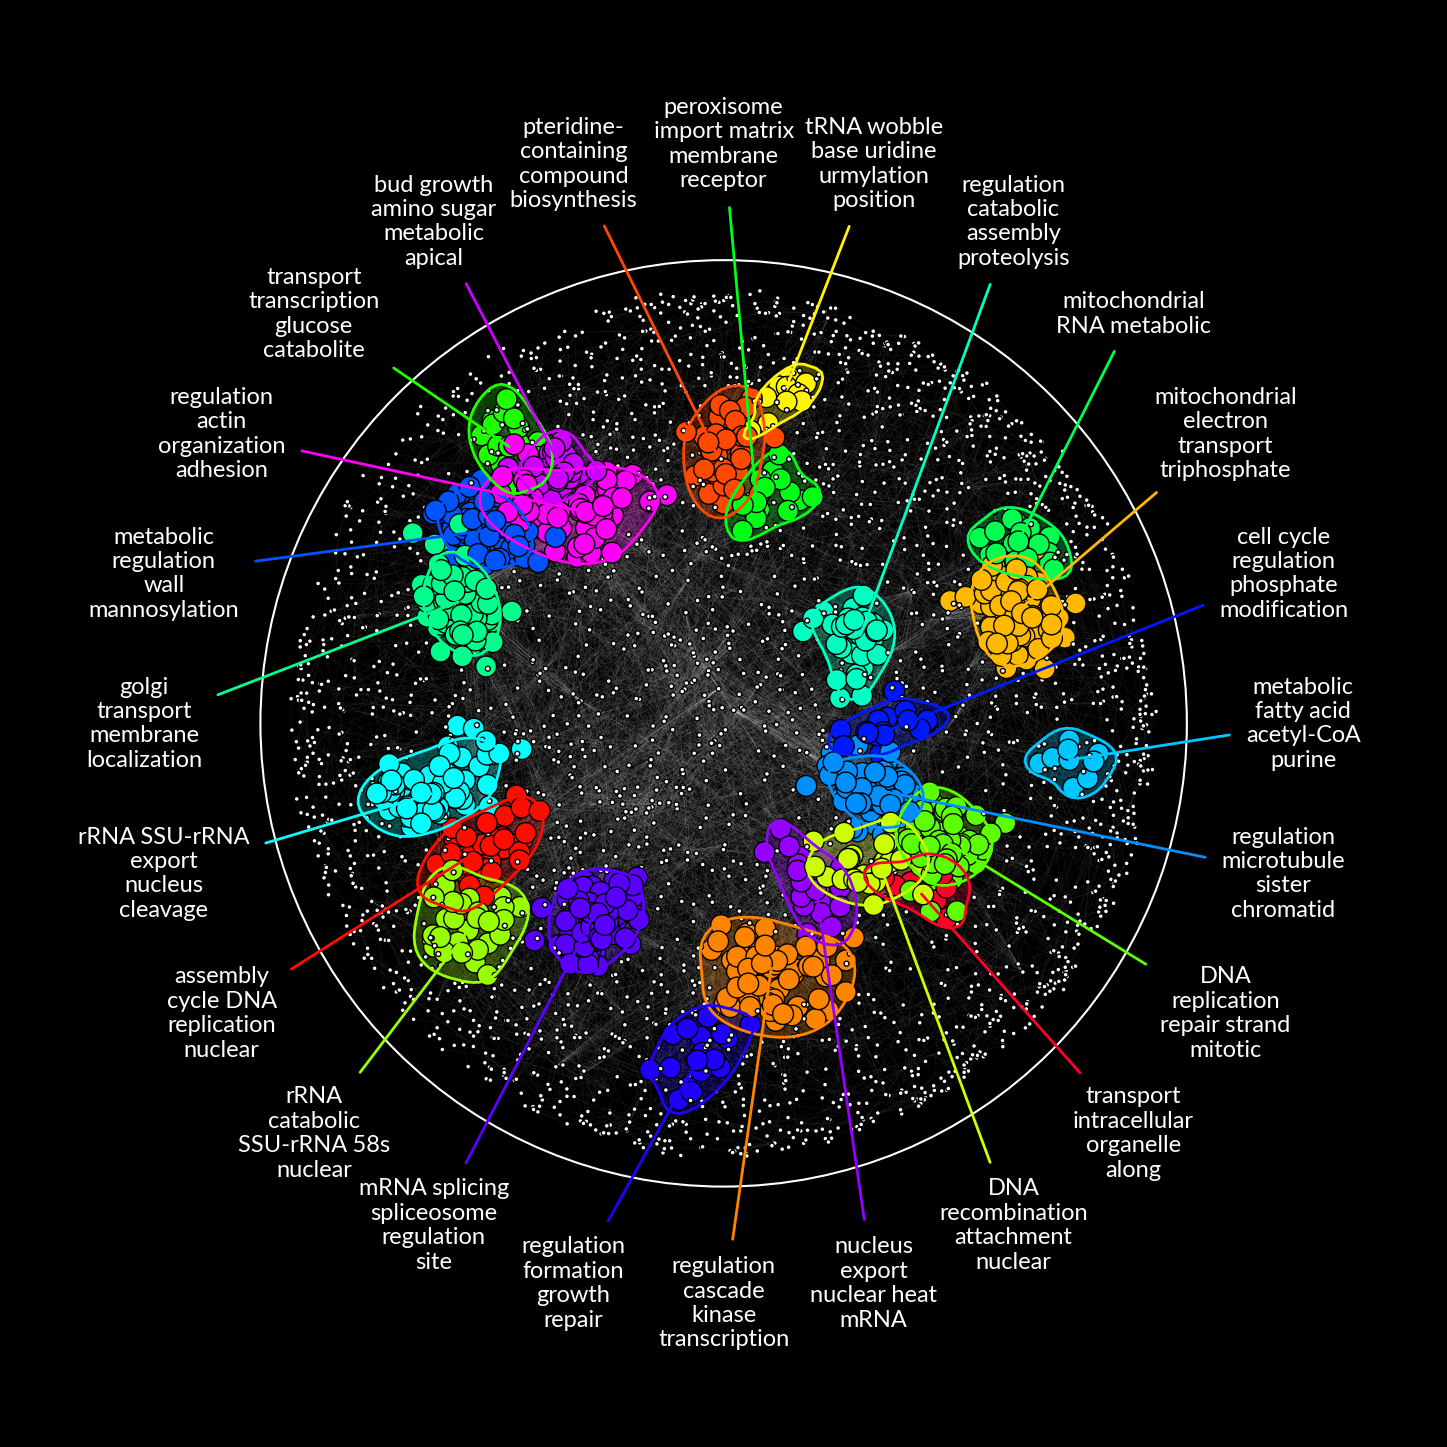

In [41]:
# Set random seed for reproducibility
random_seed = 877

# Initialize the NetworkPlotter with the NetworkGraph object
plotter = risk.load_plotter(
    graph=graph,
    figsize=(15, 15),
    background_color="black",
)

# Plot network perimeter as a circle
plotter.plot_circle_perimeter(
    scale=1.02,
    center_offset_x=0.0,
    center_offset_y=0.0,
    linestyle="solid",
    linewidth=1.5,
    color="white",
    outline_alpha=1.0,
    fill_alpha=0.0,
)

# Plot network nodes and edges
plotter.plot_network(
    node_size=plotter.get_annotated_node_sizes(
        significant_size=225,
        nonsignificant_size=12.5,
    ),
    node_shape="o",
    node_edgewidth=1.0,
    edge_width=0.03,
    node_color=plotter.get_annotated_node_colors(
        cmap="gist_rainbow",
        color=None,
        blend_colors=False,
        blend_gamma=2.2,
        min_scale=1.0,
        max_scale=1.0,
        scale_factor=0.5,
        alpha=1.0,
        nonsignificant_color="white",
        nonsignificant_alpha=0.75,
        ids_to_colors=None,
        random_seed=random_seed,
    ),
    node_edgecolor="black",
    edge_color="white",
    node_alpha=1.0,
    edge_alpha=1.0,
)

# Plot KDE-based contours around network nodes
plotter.plot_contours(
    levels=5,
    bandwidth=0.8,
    grid_size=250,
    color=plotter.get_annotated_contour_colors(
        cmap="gist_rainbow",
        blend_colors=False,
        blend_gamma=2.2,
        min_scale=1.0,
        max_scale=1.0,
        scale_factor=0.5,
        ids_to_colors=None,
        random_seed=random_seed,
    ),
    linestyle="solid",
    linewidth=2.0,
    alpha=1.0,
    fill_alpha=0.25,
)

# Plot labels on the network
plotter.plot_labels(
    scale=1.1,
    offset=0.12,
    font="Lato",
    fontcase={"title": "lower"},
    fontsize=17,  # 15
    fontcolor="white",
    fontalpha=1.0,
    arrow_linewidth=2.0,
    arrow_style="-",
    arrow_color=plotter.get_annotated_label_colors(
        cmap="gist_rainbow",
        color=None,
        blend_colors=False,
        blend_gamma=2.2,
        min_scale=1.0,
        max_scale=1.0,
        scale_factor=0.5,
        ids_to_colors=None,
        random_seed=random_seed,
    ),
    arrow_alpha=1.0,
    arrow_base_shrink=10.0,
    arrow_tip_shrink=0.0,
    max_labels=50,
    min_label_lines=2,
    max_label_lines=4,
    min_chars_per_line=3,
    max_chars_per_line=13,
    words_to_omit=[
        "process",
        "cvt",
        "budding",
        "compound",
        "one-carbon",
        "response",
        "poly",
        "transduction",
        "generate",
        "involved",
        "cell",
        "between",
        "global",
        "biosynthetic",
        "positive",
        "negative",
        "protein",
        "complex",
        "changes",
        "cis",
    ],
    overlay_ids=False,
    ids_to_keep=None,
    ids_to_labels={
        1: "pteridine-\ncontaining\ncompound\nbiosynthesis",
        15: "cell cycle\nregulation\nphosphate\nmodification",
    },
)

# 350 DPI required for journal Bioinformatics
# plotter.savefig("./png/supp_fig_1.png", bbox_inches="tight", dpi=350)

# Display the plot
plotter.show()


## Supplementary Figure S3.A

Yeast genetic interaction (GI) network from Costanzo et al. (2016), shown without annotations.

---------------
Loading plotter
---------------


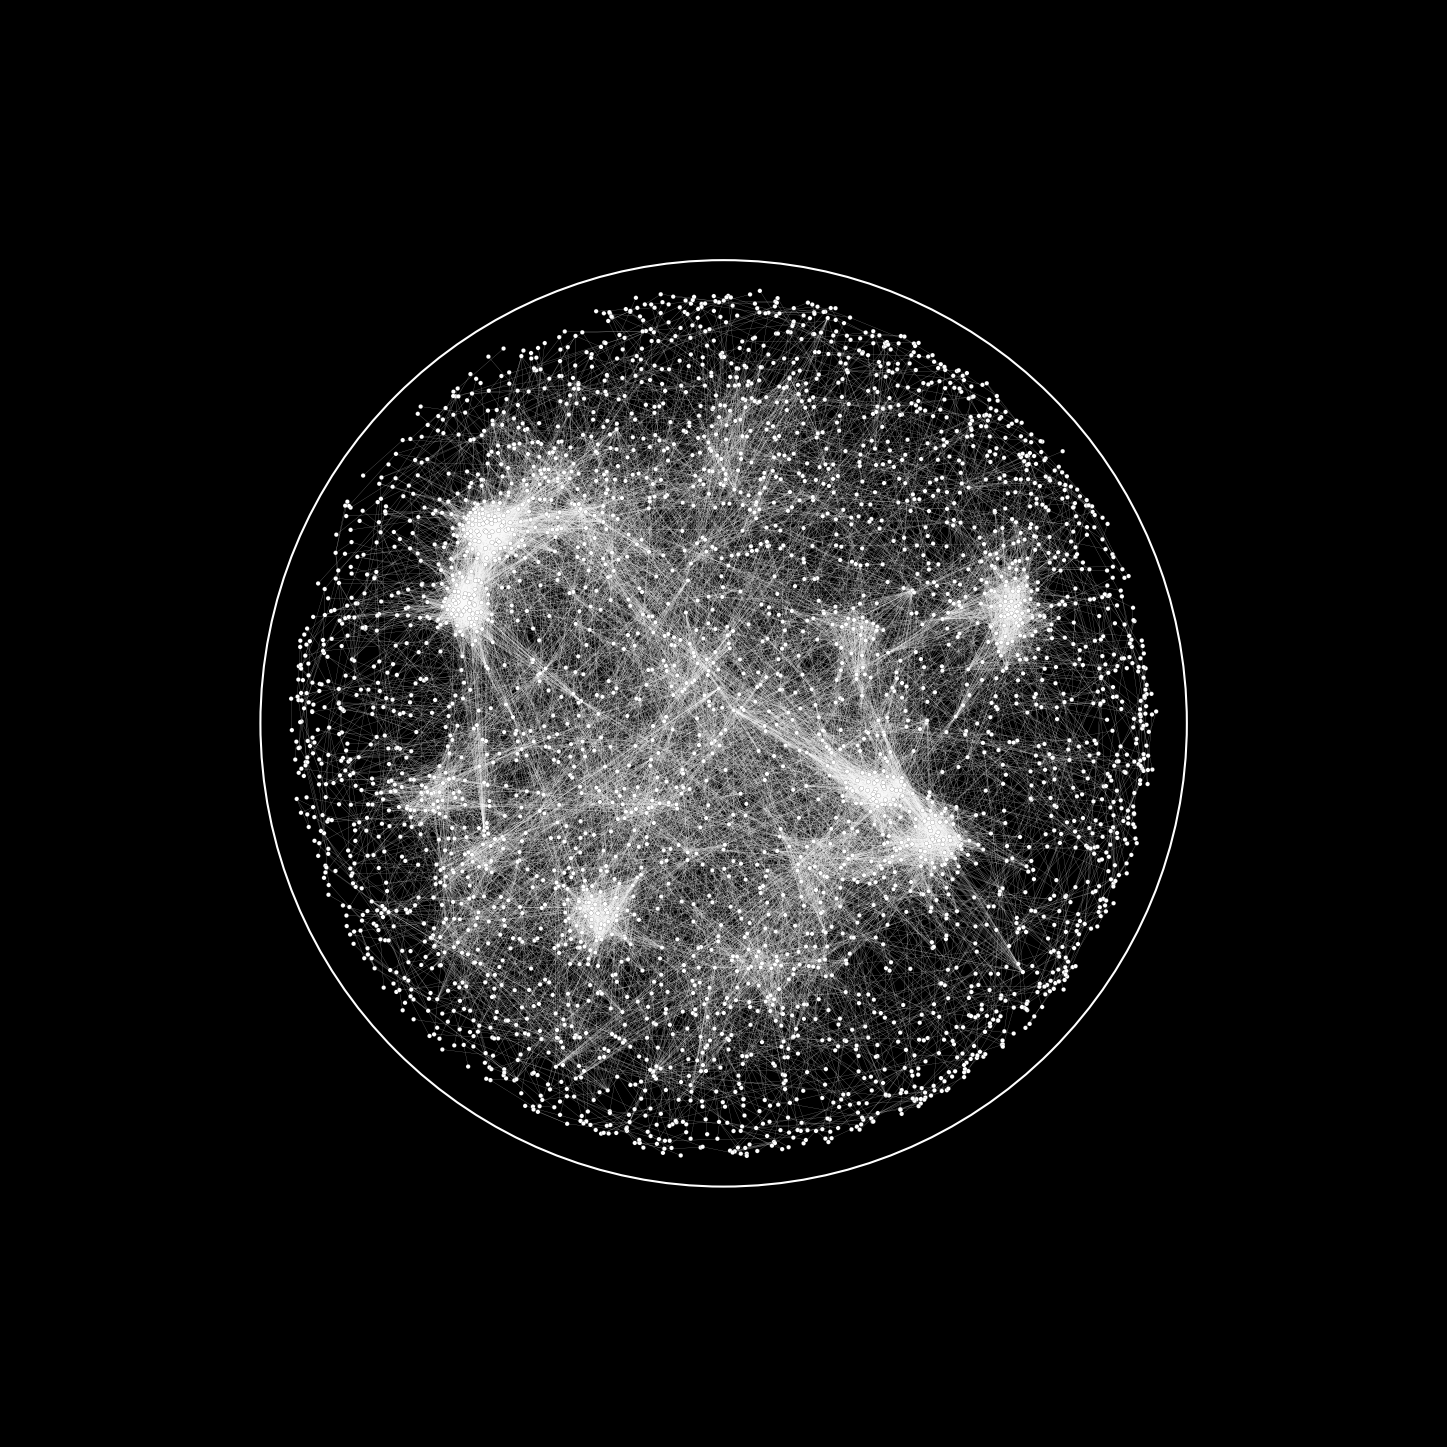

In [42]:
# Set random seed for reproducibility
random_seed = 877

# Initialize the NetworkPlotter with the NetworkGraph object
plotter = risk.load_plotter(
    graph=graph,
    figsize=(15, 15),
    background_color="black",
)

# Plot network perimeter as a circle
plotter.plot_circle_perimeter(
    scale=1.02,
    center_offset_x=0.0,
    center_offset_y=0.0,
    linestyle="solid",
    linewidth=1.5,
    color="white",
    outline_alpha=1.0,
    fill_alpha=0.0,
)

# Plot network nodes and edges
plotter.plot_network(
    node_size=plotter.get_annotated_node_sizes(
        significant_size=10,
        nonsignificant_size=10,
    ),
    node_shape="o",
    node_edgewidth=0.1,
    edge_width=0.1,
    node_color="white",
    node_edgecolor="black",
    edge_color="white",
    node_alpha=1.0,
    edge_alpha=1.0,
)

# 350 DPI required for journal Bioinformatics
# plotter.savefig("./png/supp_fig_3a.png", bbox_inches="tight", dpi=350)

# Display the plot
plotter.show()


## Supplementary Figure S3.B

Yeast genetic interaction (GI) network clustered with RISK.  
Nodes annotated with GO BP terms.

---------------
Loading plotter
---------------


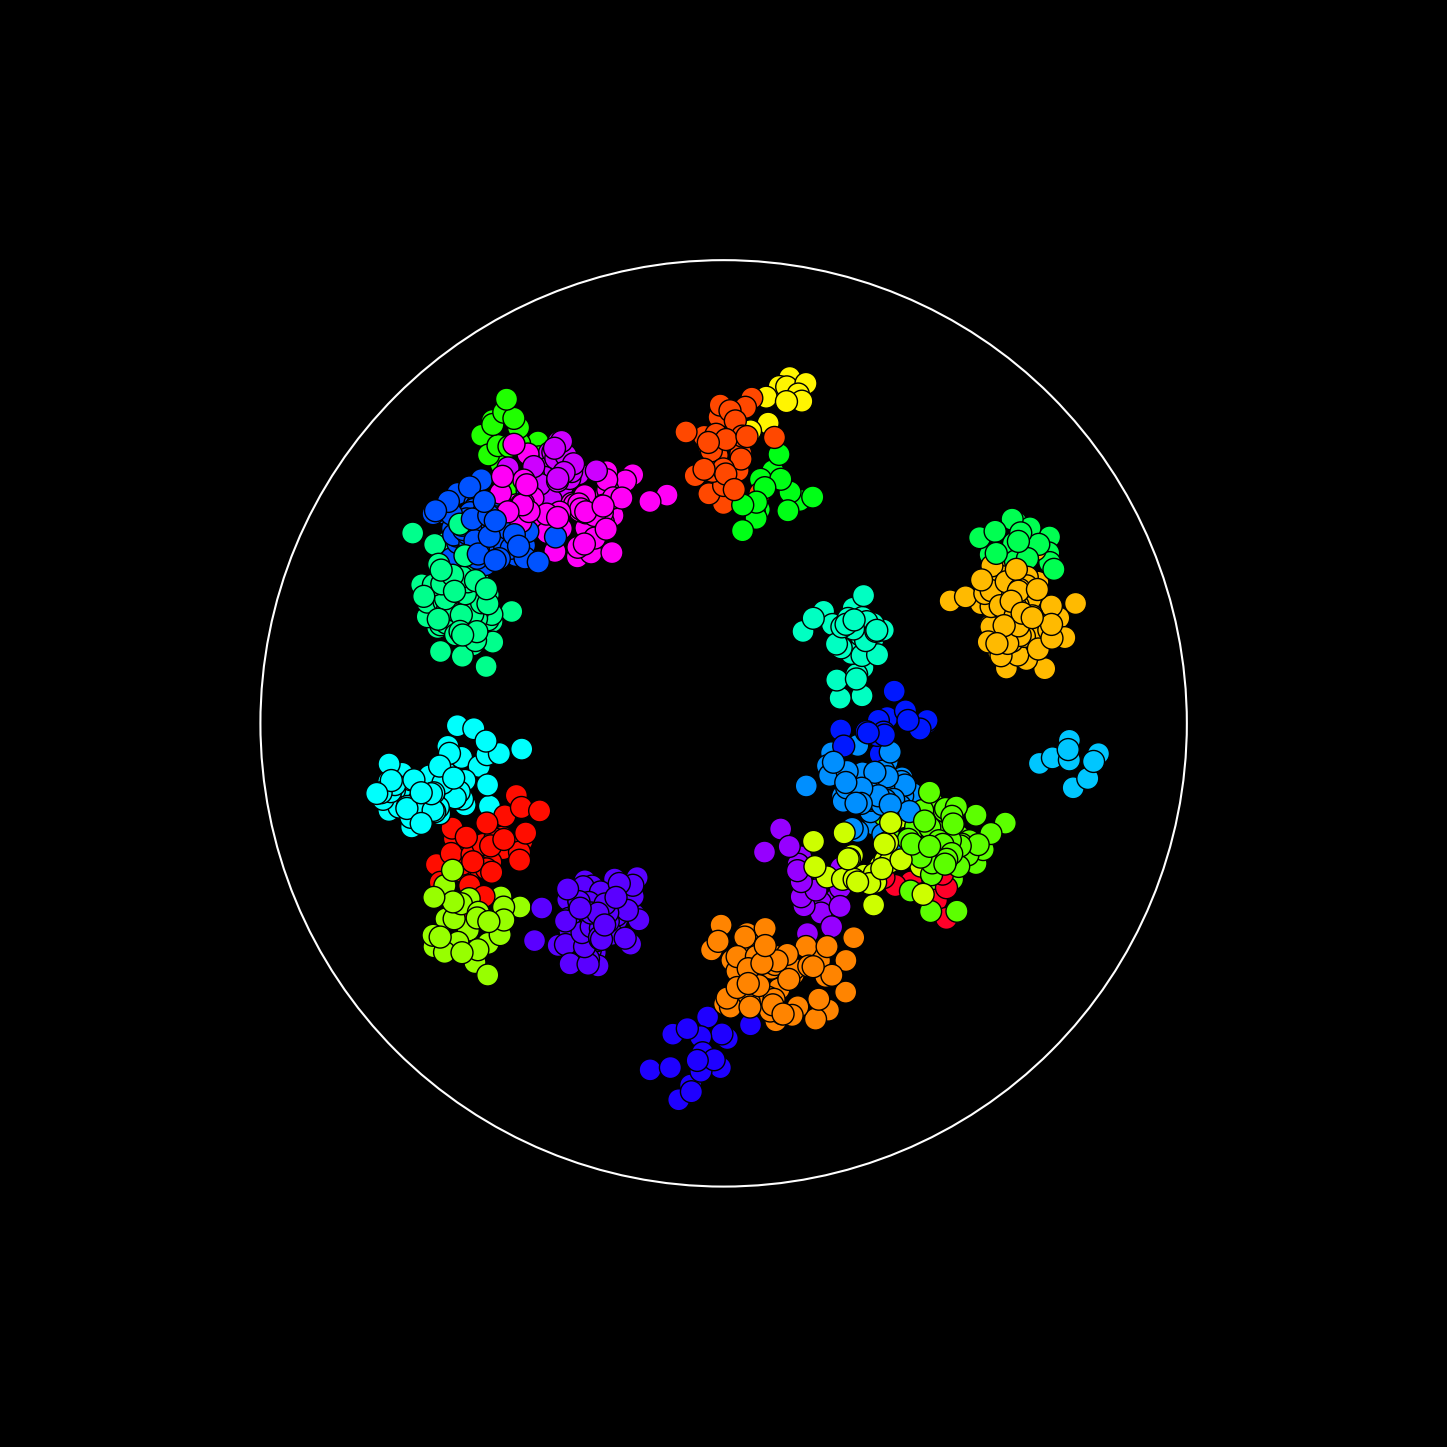

In [43]:
# Set random seed for reproducibility
random_seed = 877

# Initialize the NetworkPlotter with the NetworkGraph object
plotter = risk.load_plotter(
    graph=graph,
    figsize=(15, 15),
    background_color="black",
)

# Plot network perimeter as a circle
plotter.plot_circle_perimeter(
    scale=1.02,
    center_offset_x=0.0,
    center_offset_y=0.0,
    linestyle="solid",
    linewidth=1.5,
    color="white",
    outline_alpha=1.0,
    fill_alpha=0.0,
)

# Plot network nodes and edges
plotter.plot_network(
    node_size=plotter.get_annotated_node_sizes(
        significant_size=250,
        nonsignificant_size=0,
    ),
    node_shape="o",
    node_edgewidth=1.0,
    edge_width=0.0,
    node_color=plotter.get_annotated_node_colors(
        cmap="gist_rainbow",
        color=None,
        blend_colors=False,
        blend_gamma=2.2,
        min_scale=1.0,
        max_scale=1.0,
        scale_factor=0.5,
        alpha=1.0,
        nonsignificant_color="white",
        nonsignificant_alpha=0.75,
        ids_to_colors=None,
        random_seed=random_seed,
    ),
    node_edgecolor="black",
    edge_color="white",
    node_alpha=1.0,
    edge_alpha=1.0,
)

# 350 DPI required for journal Bioinformatics
# plotter.savefig("./png/supp_fig_3b.png", bbox_inches="tight", dpi=350)

# Display the plot
plotter.show()

## Supplementary Figure S3.D  
(see Supplementary Figure S3.C in the SAFE notebook)

Comparison of RISK and SAFE on the yeast genetic interaction (GI) network (Costanzo et al., 2016).  
Bar plot shows the number of clusters and clustering quality metrics (compactness, separation, silhouette).

In [45]:
import matplotlib.pyplot as plt


# Set the background to black for all plots
plt.rcParams["figure.facecolor"] = "black"  # Set the figure background color
plt.rcParams["axes.facecolor"] = "black"  # Set the axes background color
plt.rcParams["savefig.facecolor"] = "black"  # Set the background for saved figures
plt.rcParams["axes.edgecolor"] = "white"  # Optional: Make the axis edge white for visibility
plt.rcParams["axes.labelcolor"] = "white"  # Optional: Make axis labels white
plt.rcParams["xtick.color"] = "white"  # Optional: Make x-ticks white
plt.rcParams["ytick.color"] = "white"  # Optional: Make y-ticks white
plt.rcParams["text.color"] = "white"  # Optional: Set text color to white


In [46]:
import json


def read_json_from_file(filename):
    with open(filename, "r") as file:
        return json.load(file)


def write_json_to_file(data, filename):
    with open(filename, "w") as file:
        json.dump(data, file, indent=4)
        

In [47]:
# Define base network to use as a reference for distance-related analyses

base_network = graph.network.copy()

In [48]:
# Get RISK domain to ids

risk_domain_to_ids_map = graph.domain_id_to_node_ids_map
risk_domain_to_labels_map = graph.domain_id_to_node_labels_map
print(f"Number of domains in RISK: {len(risk_domain_to_ids_map)}")

# write_json_to_file(risk_domain_to_labels_map, './data/json/domains/20241105_risk_domains_michaelis_2023_tidied.json')


Number of domains in RISK: 24


In [49]:
# Load SAFE node ID to label map

with open(
    "../safe_network/data/json/domains/20250130_safe_node_id_to_label_costanzo_2016.json", "r"
) as json_file:
    safe_node_id_to_label_map = {int(k): v for k, v in json.load(json_file).items()}

# Get RISK label-to-node ID map
risk_label_to_node_id_map = graph.node_label_to_node_id_map

# Create mapping of SAFE node IDs to RISK node IDs based on labels
safe_to_risk_id_map = {}
for safe_id, label in safe_node_id_to_label_map.items():
    # Check if the label exists in the RISK network
    if label in risk_label_to_node_id_map:
        safe_to_risk_id_map[safe_id] = risk_label_to_node_id_map[label]
    else:
        print(f"Label '{label}' from SAFE not found in RISK network.")

# Optional: Display the mapping or save to a file
print(f"Number of mapped nodes from SAFE to RISK: {len(safe_to_risk_id_map)}")

# Get SAFE domain to ids, filtering only nodes present in RISK
with open(
    "../safe_network/data/json/domains/20250130_safe_domains_costanzo_2016.json", "r"
) as json_file:
    safe_domain_to_ids_map = {int(k): v for k, v in json.load(json_file).items()}
    # Remove 0 domain - it's garbage collection
    safe_domain_to_ids_map.pop(0, None)
    # Filter SAFE domains to only include nodes that exist in RISK
    safe_domain_to_ids_map = {
        domain: [
            safe_to_risk_id_map[node_id] for node_id in node_ids if node_id in safe_to_risk_id_map
        ]
        for domain, node_ids in safe_domain_to_ids_map.items()
    }
    # Generate labels for filtered SAFE domains
    safe_domain_to_labels_map = {
        domain: [
            graph.node_id_to_node_label_map[node_id]
            for node_id in node_ids
            if node_id in graph.node_id_to_node_label_map
        ]
        for domain, node_ids in safe_domain_to_ids_map.items()
    }

print(f"Number of domains in SAFE: {len(safe_domain_to_ids_map)}")


Number of mapped nodes from SAFE to RISK: 3971
Number of domains in SAFE: 24


In [50]:
from itertools import combinations
import numpy as np
from sklearn.metrics import silhouette_score


def calculate_network_diameter(network, exact=False):
    """
    Calculate the network diameter (maximum Euclidean distance) efficiently.
    """
    positions = np.array([[node_data["x"], node_data["y"]] for node_data in network.nodes.values()])

    if not exact:
        # Approximation using bounding box
        min_x, max_x = positions[:, 0].min(), positions[:, 0].max()
        min_y, max_y = positions[:, 1].min(), positions[:, 1].max()

        # Compute distances between extreme points of the bounding box
        extreme_points = [[min_x, min_y], [min_x, max_y], [max_x, min_y], [max_x, max_y]]
        max_distance = max(
            np.linalg.norm(np.array(p1) - np.array(p2))
            for p1, p2 in combinations(extreme_points, 2)
        )
    else:
        # Exact calculation for all pairs (O(n^2))
        max_distance = max(
            np.linalg.norm(positions[i] - positions[j])
            for i, j in combinations(range(len(positions)), 2)
        )

    return max_distance


def calculate_clustering_metrics(network, domain_to_ids_map, network_diameter=None):
    """
    Compute compactness, separation, and silhouette scores for network clusters.
    """
    compactness_scores = {}
    separation_scores = {}

    # Initialize lists for silhouette score calculation
    X = []  # List of node positions
    labels = []  # Corresponding list of cluster labels for each node

    # Compute network diameter if not provided
    if network_diameter is None:
        network_diameter = calculate_network_diameter(network, exact=False)

    # Ensure we don't divide by zero
    if network_diameter == 0:
        network_diameter = 1.0

    # Calculate compactness and separation
    centroids = {}
    for domain, node_ids in domain_to_ids_map.items():
        positions = np.array(
            [[network.nodes[node_id]["x"], network.nodes[node_id]["y"]] for node_id in node_ids]
        )

        # Compactness: Average pairwise distance within each cluster (normalized)
        if len(positions) > 1:
            pairwise_distances = [
                np.linalg.norm(positions[i] - positions[j])
                for i, j in combinations(range(len(positions)), 2)
            ]
            compactness_scores[domain] = np.mean(pairwise_distances) / network_diameter
        else:
            compactness_scores[domain] = 0  # Single-node clusters have 0 compactness by definition

        # Compute centroid for separation calculation
        centroids[domain] = np.mean(positions, axis=0)

        # Collect positions and labels for silhouette score calculation
        for pos in positions:
            X.append(pos)
            labels.append(domain)

    # Convert X and labels to NumPy arrays for consistency
    X = np.array(X)
    labels = np.array(labels)

    # Calculate separation: Minimum distance to other cluster centroids (normalized)
    for domain, centroid in centroids.items():
        other_centroids = [centroids[other] for other in centroids if other != domain]
        if other_centroids:
            min_separation = min(
                np.linalg.norm(centroid - other_centroid) for other_centroid in other_centroids
            )
            separation_scores[domain] = min_separation / network_diameter
        else:
            separation_scores[domain] = 0  # Only one cluster case

    # Calculate overall silhouette score
    overall_silhouette_score = silhouette_score(X, labels)

    # Return metrics
    return {
        "compactness": compactness_scores,
        "separation": separation_scores,
        "silhouette_score": overall_silhouette_score,
    }

In [51]:
# RISK
# Precompute network diameter

risk_network_diameter = calculate_network_diameter(base_network, exact=False)
# Calculate clustering metrics
risk_metrics = calculate_clustering_metrics(
    base_network, risk_domain_to_ids_map, network_diameter=risk_network_diameter
)

# print("Compactness per cluster:", risk_metrics['compactness'])
# print("Separation per cluster:", risk_metrics['separation'])
print("Overall Silhouette Score:", risk_metrics["silhouette_score"])

Overall Silhouette Score: 0.4059876690063511


In [52]:
# SAFE
# Precompute network diameter

safe_network_diameter = calculate_network_diameter(base_network, exact=False)
# Calculate clustering metrics
safe_metrics = calculate_clustering_metrics(
    base_network, safe_domain_to_ids_map, network_diameter=safe_network_diameter
)

# print("Compactness per cluster:", safe_metrics['compactness'])
# print("Separation per cluster:", safe_metrics['separation'])
print("Overall Silhouette Score:", safe_metrics["silhouette_score"])

Overall Silhouette Score: 0.18386394756742228


In [53]:
# This script compares clustering metrics (compactness and separation) between RISK and SAFE.
# It selects the top N clusters based on compactness for each tool, where N is the maximum common cluster count.
# Metrics are then recalculated and summarized as means and standard deviations for compactness and separation.
# Assumes `safe_metrics` and `risk_metrics` are precomputed dictionaries with 'compactness', 'separation',
# and 'silhouette_score' as keys and domain-specific metrics as values.

import numpy as np


# Assume safe_metrics and risk_metrics have already been calculated
safe_compactness = safe_metrics["compactness"]
risk_compactness = risk_metrics["compactness"]
safe_separation = safe_metrics["separation"]
risk_separation = risk_metrics["separation"]
safe_silhouette = safe_metrics["silhouette_score"]
risk_silhouette = risk_metrics["silhouette_score"]

# Determine the max count of clusters between SAFE and RISK
max_cluster_count = min(len(safe_compactness), len(risk_compactness))

# Sort and select top N clusters based on compactness
top_safe_compactness = dict(
    sorted(safe_compactness.items(), key=lambda item: item[1])[:max_cluster_count]
)
top_risk_compactness = dict(
    sorted(risk_compactness.items(), key=lambda item: item[1])[:max_cluster_count]
)

top_safe_separation = {domain: safe_separation[domain] for domain in top_safe_compactness}
top_risk_separation = {domain: risk_separation[domain] for domain in top_risk_compactness}

# Re-calculate the means of the selected top clusters
safe_compactness_mean = np.mean(list(top_safe_compactness.values()))
safe_compactness_std = np.std(list(top_safe_compactness.values()))
risk_compactness_mean = np.mean(list(top_risk_compactness.values()))
risk_compactness_std = np.std(list(top_risk_compactness.values()))

safe_separation_mean = np.mean(list(top_safe_separation.values()))
safe_separation_std = np.std(list(top_safe_separation.values()))
risk_separation_mean = np.mean(list(top_risk_separation.values()))
risk_separation_std = np.std(list(top_risk_separation.values()))

# Print results
print("Top N SAFE Compactness (mean, std):", safe_compactness_mean, safe_compactness_std)
print("Top N RISK Compactness (mean, std):", risk_compactness_mean, risk_compactness_std)
print("Top N SAFE Separation (mean, std):", safe_separation_mean, safe_separation_std)
print("Top N RISK Separation (mean, std):", risk_separation_mean, risk_separation_std)

Top N SAFE Compactness (mean, std): 0.06330114389423856 0.035020999616932495
Top N RISK Compactness (mean, std): 0.033023017678132406 0.005726038498642908
Top N SAFE Separation (mean, std): 0.05503329375779135 0.023845403101840794
Top N RISK Separation (mean, std): 0.061162482059445605 0.020668441504099862


# SAFE Groups: 24 : # RISK Groups: 24
Compactness Mann-Whitney U: U=469.0, p-value=9.888531861250731e-05
Separation Mann-Whitney U: U=207.0, p-value=0.0484101760047968
Silhouette Score Mann-Whitney U: U=0.0, p-value=1.0


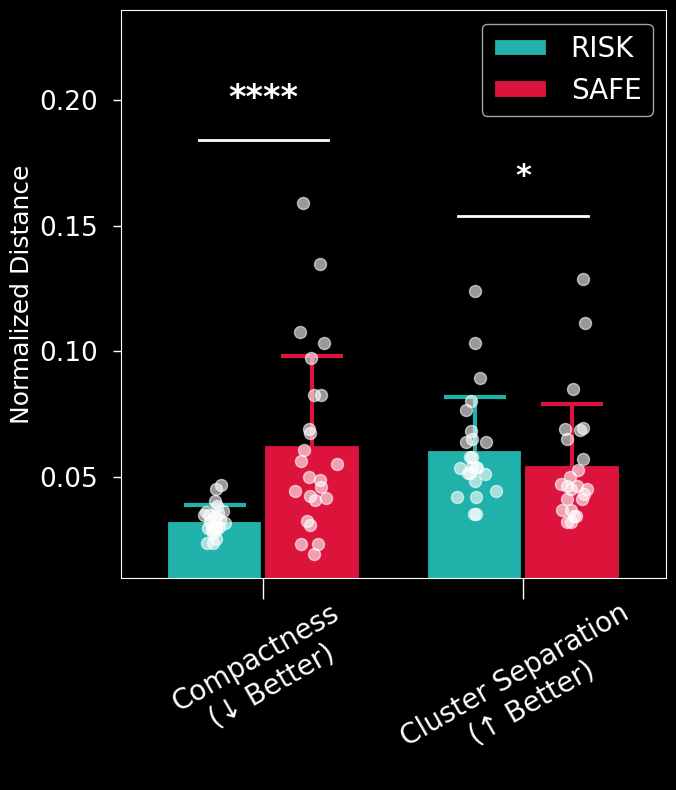

In [54]:
# This script generates a comparative bar chart and scatter plot to visualize clustering metrics 
# (compactness, separation, silhouette score) for SAFE and RISK. It includes statistical significance 
# testing using the Mann-Whitney U test to assess differences between the tools. Annotations highlight 
# significant results directly on the plot. This visualization is tailored for publication-quality 
# figures and supports a critical evaluation of clustering performance across metrics.

# Key Features:
# 1. Bar chart with error bars for compactness and separation.
# 2. Scatter points for silhouette scores.
# 3. Jittered scatter points overlaid on bars to represent individual cluster metrics.
# 4. Mann-Whitney U test results annotated for significance.
# 5. Flexible y-axis range adjustment and aesthetic customization for publication readiness.

# Inputs:
# - Precomputed SAFE and RISK metrics (compactness, separation, silhouette scores).
# - Statistical significance thresholds for Mann-Whitney U test annotations.

# Outputs:
# - Comparative bar chart with significance annotations.
# - Printout of Mann-Whitney U test results for compactness, separation, and silhouette score.

from matplotlib.ticker import MultipleLocator
from scipy.stats import mannwhitneyu


np.random.seed(888)

# Example data (replace with actual values)
metrics = [
    "Compactness\n(↓ Better)",
    "Cluster Separation\n(↑ Better)",
    "Silhouette Score\n(↑ Better)",
]
safe_means = [safe_compactness_mean, safe_separation_mean, safe_silhouette]
safe_stds = [safe_compactness_std, safe_separation_std, 0]  # No std deviation for silhouette
risk_means = [risk_compactness_mean, risk_separation_mean, risk_silhouette]
risk_stds = [risk_compactness_std, risk_separation_std, 0]  # No std deviation for silhouette

print(f"# SAFE Groups: {len(safe_compactness)} : # RISK Groups: {len(risk_compactness)}")
safe_data = [list(safe_compactness.values()), list(safe_separation.values()), [safe_silhouette]]
risk_data = [list(risk_compactness.values()), list(risk_separation.values()), [risk_silhouette]]

# Bar chart settings
fig, ax = plt.subplots(figsize=(8, 8))
bar_width = 0.375
x = np.arange(len(metrics) - 1)

safe_color = "#DC143C"  # Crimson for SAFE
risk_color = "#20B2AA"  # Light Sea Green for RISK

# Plot RISK bars first (swap positions with SAFE)
ax.bar(
    x - bar_width / 2,
    risk_means[:2],
    bar_width,
    yerr=risk_stds[:2],
    color=risk_color,
    edgecolor="black",
    linewidth=3,
    capsize=22,
    label="RISK",
    error_kw=dict(ecolor=risk_color, lw=3, capthick=3),
)
ax.bar(
    x + bar_width / 2,
    safe_means[:2],
    bar_width,
    yerr=safe_stds[:2],
    color=safe_color,
    edgecolor="black",
    linewidth=3,
    capsize=22,
    label="SAFE",
    error_kw=dict(ecolor=safe_color, lw=3, capthick=3),
)

# Overlay white jittered scatter points with transparency for RISK
for i, data in enumerate(risk_data[:2]):
    jitter = np.random.normal(0, 0.03, len(data))  # Small jitter
    ax.scatter(
        np.full(len(data), x[i] - bar_width / 2) + jitter,
        data,
        color="white",
        s=75,
        alpha=0.6,
        zorder=3,
    )

# Overlay white jittered scatter points with transparency for SAFE
for i, data in enumerate(safe_data[:2]):
    jitter = np.random.normal(0, 0.03, len(data))  # Small jitter
    ax.scatter(
        np.full(len(data), x[i] + bar_width / 2) + jitter,
        data,
        color="white",
        s=75,
        alpha=0.6,
        zorder=3,
    )

# Customizations
ax.axhline(
    0, color="white", linewidth=1.5, linestyle="--"
)  # Solid white line at y=0 as reference point
ax.set_xticks(
    np.append(x, x[-1] + 1)
)  # Adjust x-axis ticks to include the silhouette score position
ax.set_xticklabels(metrics, fontsize=20)  # Set x-axis label font size

# Extend x and y tick marks
ax.tick_params(axis="x", pad=0, length=15, width=1)  # Extend x-axis tick marks towards labels
ax.tick_params(axis="y", pad=10, length=6, width=1)  # Extend y-axis tick marks towards labels

# CHANGE HERE FOR YLIM
correction = (max(safe_data[0]) - min(safe_data[0])) * 0.55
ax.set_ylim(0.01, max(safe_data[0]) + correction)  # Adjust the y-axis range as needed
ax.legend(loc="upper right", fontsize=20)  # Increase legend font size
# Set the y-axis tick interval
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.set_ylabel("Normalized Distance", fontsize=18)
ax.tick_params(axis="y", labelsize=19)  # Customize y-tick font size

plt.xticks(rotation=30)  # Rotate x-tick labels
plt.tight_layout()
# Create a 5% (0.05) and 10% (0.1) padding in the
# x and y directions respectively.
plt.margins(0.1, 0)

# Convert compactness and separation to lists of numeric values
safe_compactness_values = list(safe_compactness.values())
risk_compactness_values = list(risk_compactness.values())
safe_separation_values = list(safe_separation.values())
risk_separation_values = list(risk_separation.values())

# Perform Mann-Whitney U test for each metric
compactness_stat, compactness_p = mannwhitneyu(
    safe_compactness_values, risk_compactness_values, alternative="greater"
)
separation_stat, separation_p = mannwhitneyu(
    safe_separation_values, risk_separation_values, alternative="less"
)
silhouette_stat, silhouette_p = mannwhitneyu(
    [safe_metrics["silhouette_score"]], [risk_metrics["silhouette_score"]], alternative="two-sided"
)

# Print results
print(f"Compactness Mann-Whitney U: U={compactness_stat}, p-value={compactness_p}")
print(f"Separation Mann-Whitney U: U={separation_stat}, p-value={separation_p}")
print(f"Silhouette Score Mann-Whitney U: U={silhouette_stat}, p-value={silhouette_p}")

# Define significance thresholds
significance_annotations = {
    "****": 0.0001,
    "***": 0.001,
    "**": 0.01,
    "*": 0.05,
}


def get_significance_text(p_value):
    for text, threshold in significance_annotations.items():
        if p_value <= threshold:
            return text
    return "n.s."  # Not significant


# Get significance text for each metric
compactness_text = get_significance_text(compactness_p)
separation_text = get_significance_text(separation_p)

# Annotate significance on the plot
safe_compactness_height = max(safe_compactness_values) + 0.025
ax.text(
    0,
    safe_compactness_height + 0.01,
    compactness_text,
    ha="center",
    va="bottom",
    color="white",
    weight="bold",
    fontsize=24,
)
ax.plot(
    [-0.25, 0.25], [safe_compactness_height, safe_compactness_height], color="white", linewidth=2
)

risk_separation_height = max(safe_separation_values) + 0.025
ax.text(
    1,
    risk_separation_height + 0.01,
    separation_text,
    ha="center",
    va="bottom",
    color="white",
    weight="bold",
    fontsize=22,
)
ax.plot([0.75, 1.25], [risk_separation_height, risk_separation_height], color="white", linewidth=2)

# 1,200 DPI required for line art in journal Bioinformatics
# plt.savefig("./png/supp_fig_3d.png", bbox_inches="tight", dpi=1200)

plt.show()